In [11]:
%matplotlib notebook
# Calculation of a magnetic field of a wire
# https://stackoverflow.com/questions/4969704/python-calculate-the-magnetic-field-of-a-wire-using-biot-savart-law
# Other alternative codes:
# https://github.com/grungy/staticbs
# https://someusefulcode.wordpress.com/2012/05/07/a-simple-biot-savart-solver-in-python/

# Retrieve libraries
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Import and define physical constants
from pylab import *
from scipy import constants 
constant = constants.mu_0/(4*np.pi)

# Instruction to print entirety of arrays
np.set_printoptions(threshold=np.inf)

# Lei de Biot-Savart
$$ d{\bf{B}} = \frac{{\mu _0 }}{{4\pi }}\frac{{Id\ell \times {\bf{\hat r}}}}{{r^2 }}$$

In [12]:
# Current in coil, positive goes anti-clockwise in Z-axis
I = 19e-3 * 20 

a=0.454/2.0 # Y coil half-length
b=0.089/2.0 # X coil half-length

DLi=0.001 # line integral 'unit' length

# Coil is in Plane XY
# wire vertices position. 
coord = [(b,a), (-b,a), (-b, -a), (b,-a), (b,a)]

# Will store all positions connecting parts (read below)
coord2 = []

# divide path of the wire in parts of length DLi
parts = 0
for n in range(len(coord)-1):
    lengthx = coord[n+1][0] - coord[n][0]
    lengthy = coord[n+1][1] - coord[n][1]
    length = np.sqrt(lengthx**2 + lengthy**2) / DLi
    for m in range(int(length)):
        coord2.append((coord[n][0]+lengthx/length*m, coord[n][1]+lengthy/length*m))
        parts += 1

# calculate the b-field integral, return vector
def bfield(x,y,z):
    # Make empty matrix
    b = np.zeros((1,3))
    # Part length
    for i in range(parts-1):
        dlx = coord2[i+1][0]-coord2[i][0]
        dly = coord2[i+1][1]-coord2[i][1] 
        dlz = 0
        dl = np.array([dlx,dly,dlz])
        # Distance to part
        rspace_minus_rwire_x = x - (coord2[i][0]+dlx)
        rspace_minus_rwire_y = y - (coord2[i][1]+dly)
        rspace_minus_rwire_z = z - 0
        rspace_minus_rwire = np.array([rspace_minus_rwire_x, rspace_minus_rwire_y, rspace_minus_rwire_z])
        # Distance modulum
        absr = (rspace_minus_rwire_x**2 + rspace_minus_rwire_y**2 + rspace_minus_rwire_z**2)**0.5
        # Calculate b-field for each part
        a = constant * I * np.cross(dl, rspace_minus_rwire) / absr**3
        # Accumulate integral for total field from all parts
        b += a 
    return b

In [14]:
#Mesh for Contour Plot
xpoints=26
ypoints=26
xwidth =0.4
ywidth =0.4
z = 0.01
bmatrix = np.zeros((xpoints,ypoints))
x = np.linspace(0.0, xwidth, xpoints)# (range(xpoints)*xwidth)/xpoints
y = np.linspace(0.0, ywidth, ypoints)#(range(ypoints)*ywidth)/ypoints

for i in range(xpoints):
    for j in range(ypoints):
        vect=bfield(x[i],y[j],z)
        bmatrix[i][j] = np.linalg.norm(vect)


<IPython.core.display.Javascript object>


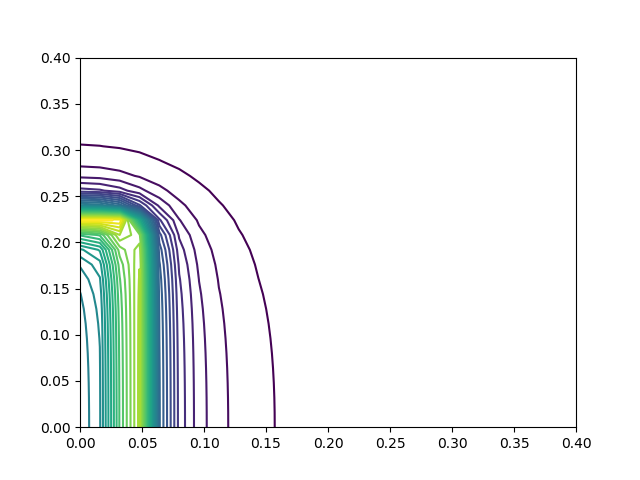

In [15]:
# visualize Contour Plot (slow)
plt.figure()
z = bmatrix.T
contour(x,y,z,35)
plt.show()

# Probe Field computation
## Probe is on XZ Plane, on a line rotated Phi, ($\Phi$) from X-axis anti-clockwise

In [20]:
# Angle in degrees (there is a 1 degree offset)  -  <<Change angle here>>
Phi=np.radians(0)
# Define cosine and sine
c, s = np.cos(Phi), np.sin(Phi)

# Number of points to calc  -  <<Can be changed>>
Npoints=100
# Probe distance from origin of movement to end of movement -  <<Can be changed>>
pointsL = np.linspace(0.015,0.20, Npoints)           
                                  


In [21]:
# Store field values for each point
Bprobe= np.zeros((Npoints, 1, 3))
Bmag= np.zeros((Npoints, 1))

for i in range(Npoints):
        Bprobe[i] = bfield(pointsL[i] * c - 0.0105 * s, 0.0, pointsL[i] * s + 0.0105 * c)

Bmag= np.linalg.norm(Bprobe, axis=(1,2))

In [22]:
# Rotation matrix to place b-field in Probe reference axis
rot_matrix = np.array([[-c, 0, -s],                 
                     [0, 1, 0],
                     [-s, 0, c]])

# Will store rotated field values for each point
Brot  = np.zeros(( Npoints, 1, 3))                 
for i in range(Npoints):
    Brot[i] = np.matmul(Bprobe[i], rot_matrix.T )


<IPython.core.display.Javascript object>


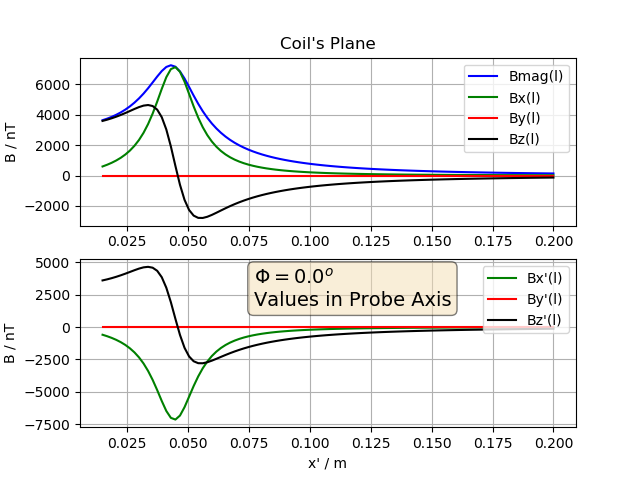

In [23]:
# Display graph of magnetic field in lab ref axis vs probe ref axis
fig = plt.figure()
ax1 = fig.add_subplot(211) # , autoscale_on=False, xlim=(0.8, 2), ylim=(0, 0.1))
ax2 = fig.add_subplot(212) #, , autoscale_on=False, xlim=(0.8, 2), ylim=(0, 0.1)) #, autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1))

ax1.plot(pointsL, 1e9* Bmag, 'b', label='Bmag(l)')
ax1.plot(pointsL, 1e9* Bprobe[:,:,0], 'g', label='Bx(l)')
ax1.plot(pointsL, 1e9* Bprobe[:,:,1], 'r', label='By(l)')
ax1.plot(pointsL, 1e9* Bprobe[:,:,2], 'k', label='Bz(l)')
ax1.set_ylabel('B / nT'), ax2.set_ylabel('B / nT')
ax1.set_title("Coil's Plane") #, ax2.set_title('Sensor Plane')
ax1.grid(), ax2.grid()
ax2.set_xlabel("x' / m")

ax2.plot(pointsL, 1e9* Brot[:,:,0], 'g', label="Bx'(l)")
ax2.plot(pointsL, 1e9* Brot[:,:,1], 'r', label="By'(l)")
ax2.plot(pointsL, 1e9* Brot[:,:,2], 'k', label="Bz'(l)")
ax1.legend(loc='best'), ax2.legend(loc='upper right')
# these are matplotlib.patch.Patch properties
textstr = '$\Phi=%.1f ^o$\nValues in Probe Axis'%(Phi)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax2.text(0.35, 0.95, textstr, transform=ax2.transAxes, fontsize=14, verticalalignment='top', bbox=props)
fig.show()

In [ ]:
# Compute here the Field in any position (Coil coordinates), in nT
1e9 * Brot(0.25, 0.0, 0.0)

In [ ]:
# Print here array of b-field values for comparison, in nT
1e9 * Brot  